# Map patients to relapse networks

In [1]:
import os,importlib,numpy,json

import scipy,scipy.stats

import miner_20190520 as miner

import pandas
pandas.options.display.max_rows=100
pandas.set_option('display.max_colwidth',-1)

import matplotlib,matplotlib.pyplot
matplotlib.pyplot.rcParams['axes.axisbelow']=True
matplotlib.rcParams.update({'font.size':18,'font.family':'Arial','xtick.labelsize':20,'ytick.labelsize':20,'axes.labelsize':30})
matplotlib.rcParams['pdf.fonttype']=42

# 0. User defined variables

In [2]:
expression_data_file='/Users/adrianlopezgarciadelomana/gd/projects/MINER/shared/MINER/data/expression/IA12Zscore.csv'
regulonDf_file='/Users/adrianlopezgarciadelomana/gd/projects/MINER/shared/MINER/results_minCorrelation_0o2_50_allFiles/regulonDf.csv'
overExpressedMembersMatrix_file='/Users/adrianlopezgarciadelomana/gd/projects/MINER/shared/MINER/results_minCorrelation_0o2_50_allFiles/overExpressedMembers.csv'

In [3]:
expression_data_file='/Users/alomana/Google Drive File Stream/My Drive/projects/MINER/shared/MINER/data/expression/IA12Zscore.csv'
regulonDf_file='/Users/alomana/Google Drive File Stream/My Drive/projects/MINER/shared/MINER/results_minCorrelation_0o2_50_allFiles/regulonDf.csv'
overExpressedMembersMatrix_file='/Users/alomana/Google Drive File Stream/My Drive/projects/MINER/shared/MINER/results_minCorrelation_0o2_50_allFiles/overExpressedMembers.csv'

# 1. Read data

In [4]:
expressionData, conversionTable = miner.preprocess(expression_data_file)

completed identifier conversion.
16216 genes were converted.


In [5]:
regulonDf = pandas.read_csv(regulonDf_file,index_col=0,header=0)

In [6]:
overExpressedMembersMatrix = pandas.read_csv(overExpressedMembersMatrix_file,index_col=0,header=0)

# 2.  Analysis

## 2.1 Find relapse signatures using all baseline

In [7]:
# Define phenotypes of interest
all_patients=[patient for patient in list(expressionData.columns) if patient.split('_')[-1] == 'BM']
baseline_patients=[pat for pat in all_patients if pat.split("_")[2] == '1']
first_relapse_patients=[pat for pat in all_patients if pat.split("_")[2] == '2']
relapse_patients=[pat for pat in all_patients if pat.split("_")[2] != '1']
multiple_relapse_patients=list(set(relapse_patients)-set(first_relapse_patients))

phenotype1=baseline_patients
phenotype2=relapse_patients

print('Found {} background events.'.format(len(phenotype1)))
print(phenotype1[:10])
print('')
print('Found {} relapse events.'.format(len(phenotype2)))
print(phenotype2[:10])

Found 767 background events.
['MMRF_1270_1_BM', 'MMRF_1037_1_BM', 'MMRF_2644_1_BM', 'MMRF_1235_1_BM', 'MMRF_1621_1_BM', 'MMRF_2313_1_BM', 'MMRF_1936_1_BM', 'MMRF_2006_1_BM', 'MMRF_2720_1_BM', 'MMRF_1654_1_BM']

Found 97 relapse events.
['MMRF_1518_3_BM', 'MMRF_1650_2_BM', 'MMRF_1433_4_BM', 'MMRF_1931_2_BM', 'MMRF_2373_2_BM', 'MMRF_1686_2_BM', 'MMRF_1284_2_BM', 'MMRF_1229_3_BM', 'MMRF_2089_3_BM', 'MMRF_1500_2_BM']


completed in 1.89 minutes


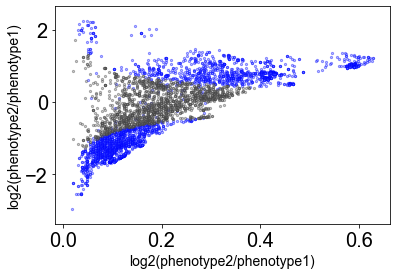

In [8]:
volcano_data = miner.differentialActivity(regulon_matrix = regulonDf.copy(),reference_matrix = overExpressedMembersMatrix.copy(),baseline_patients=phenotype1,relapse_patients=phenotype2,maxRegulons = 3,minRegulons = 3,useAllRegulons = False,savefile = 'figure.pdf')

In [9]:
volcano_data.head()

,phenotype1_frequency,phenotype2_frequency,log2(phenotype2/phenotype1),-log10(p)
ENSG00000076003,0.222947,0.572165,1.359733,12.816741
ENSG00000119403,0.247392,0.600515,1.279400,12.487511
ENSG00000162704,0.239896,0.590206,1.298812,12.420180
ENSG00000094916,0.223598,0.567010,1.342465,12.412508
ENSG00000117632,0.236636,0.585052,1.305893,12.400601


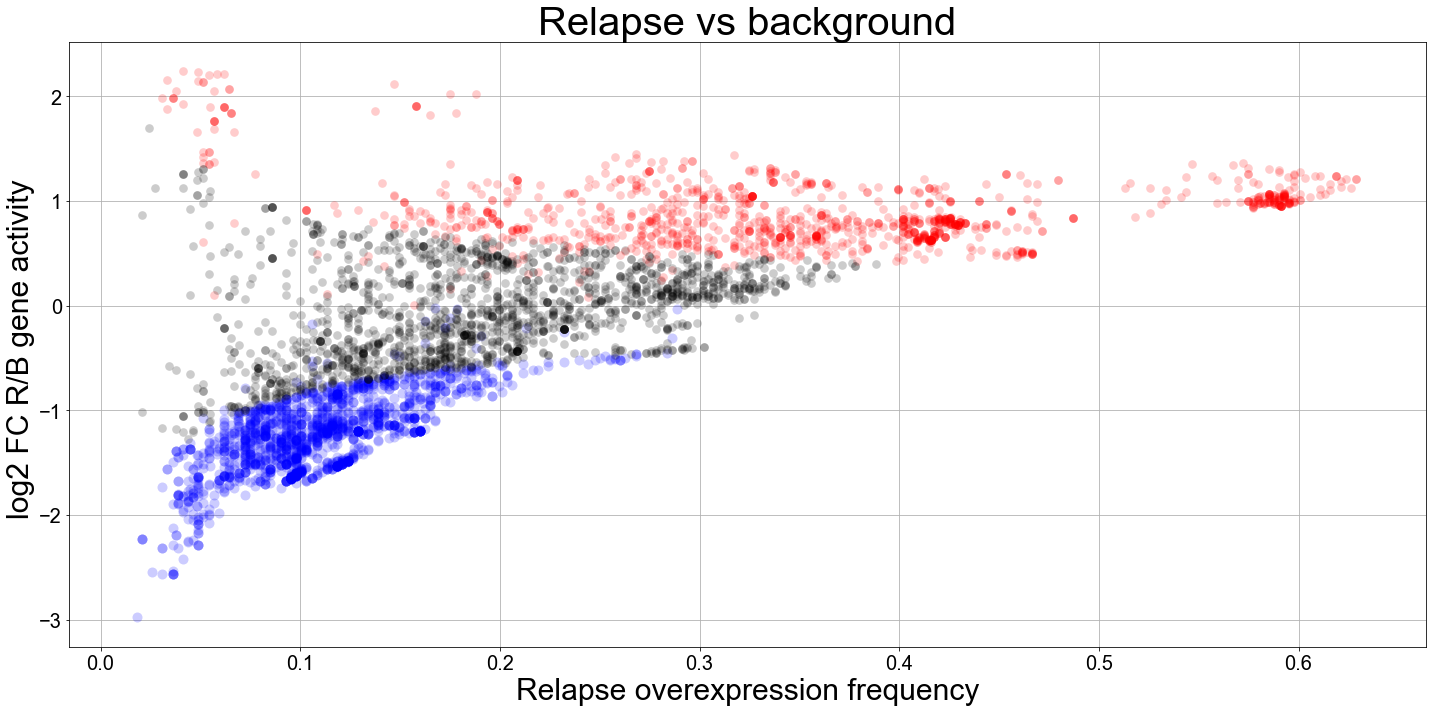

In [10]:
insigvoldata_patients = volcano_data.index[volcano_data["-log10(p)"]<=-numpy.log10(0.05)]
sigvoldata_patients_plus = volcano_data.index[(volcano_data["-log10(p)"] > -numpy.log10(0.05)) & (volcano_data['log2(phenotype2/phenotype1)'] > 0)]
sigvoldata_patients_minus = volcano_data.index[(volcano_data["-log10(p)"] > -numpy.log10(0.05)) & (volcano_data['log2(phenotype2/phenotype1)'] < 0)]

insigvoldata = volcano_data.loc[insigvoldata_patients,:]
sigvoldata_plus = volcano_data.loc[sigvoldata_patients_plus,:]
sigvoldata_minus = volcano_data.loc[sigvoldata_patients_minus,:]

fig = matplotlib.pyplot.figure(figsize=(20,10))

matplotlib.pyplot.scatter(sigvoldata_plus["phenotype2_frequency"],numpy.array(sigvoldata_plus["log2(phenotype2/phenotype1)"]),color = 'red',alpha=0.2,s=75,linewidths=0)

matplotlib.pyplot.scatter(sigvoldata_minus["phenotype2_frequency"],numpy.array(sigvoldata_minus["log2(phenotype2/phenotype1)"]),color = 'blue',alpha=0.2,s=100,linewidths=0)

matplotlib.pyplot.scatter(insigvoldata["phenotype2_frequency"],numpy.array(insigvoldata["log2(phenotype2/phenotype1)"]),color ='black',edgecolor = [0.1,0.1,0.1],alpha=0.2,s=75,linewidths=0)

matplotlib.pyplot.ylabel("log2 FC R/B gene activity ")
matplotlib.pyplot.xlabel("Relapse overexpression frequency")
matplotlib.pyplot.title('Relapse vs background',fontsize=40)
matplotlib.pyplot.grid()
matplotlib.pyplot.tight_layout()

In [11]:
print(sigvoldata_plus.shape)
print(sigvoldata_minus.shape)
full_df=pandas.concat([sigvoldata_plus,sigvoldata_minus])
print(full_df.shape)
full_df.rename(columns={'phenotype1_frequency':'background_frequency','phenotype2_frequency':'relapse_frequency','log2(phenotype2/phenotype1)':'log2(relapse/background)'},inplace=True)
full_df.to_csv(path_or_buf='relapse_vs_background.v2.csv')
full_df.head()

(1209, 4)
(1736, 4)
(2945, 4)


,background_frequency,relapse_frequency,log2(relapse/background),-log10(p)
ENSG00000076003,0.222947,0.572165,1.359733,12.816741
ENSG00000119403,0.247392,0.600515,1.279400,12.487511
ENSG00000162704,0.239896,0.590206,1.298812,12.420180
ENSG00000094916,0.223598,0.567010,1.342465,12.412508
ENSG00000117632,0.236636,0.585052,1.305893,12.400601


## 2.2 Find relapse signatures using matched patients

In [12]:
relapse_events = [pat for pat in all_patients if pat.split("_")[2] != '1']
relapse_events.sort()

baseline_patients=[]; relapse_patients=[]

for event in relapse_events:
    label=event.split('_')[1]
    baseline_label='MMRF_{}_1_BM'.format(label)
    if baseline_label in all_patients:
        baseline_patients.append(baseline_label)
        if 'BM' in event:
            relapse_patients.append(event)
        
baseline_patients=list(set(baseline_patients))
relapse_patients=list(set(relapse_patients))

baseline_patients.sort()
relapse_patients.sort()

phenotype1 = baseline_patients
phenotype2 = relapse_patients

print('Found {} baseline events.'.format(len(phenotype1)))
print(phenotype1[:10])
print('')
print('Found {} relapse events.'.format(len(phenotype2)))
print(phenotype2[:10])

Found 58 baseline events.
['MMRF_1024_1_BM', 'MMRF_1030_1_BM', 'MMRF_1079_1_BM', 'MMRF_1137_1_BM', 'MMRF_1157_1_BM', 'MMRF_1179_1_BM', 'MMRF_1201_1_BM', 'MMRF_1224_1_BM', 'MMRF_1229_1_BM', 'MMRF_1235_1_BM']

Found 70 relapse events.
['MMRF_1024_2_BM', 'MMRF_1024_3_BM', 'MMRF_1030_3_BM', 'MMRF_1079_2_BM', 'MMRF_1137_3_BM', 'MMRF_1137_4_BM', 'MMRF_1157_2_BM', 'MMRF_1157_3_BM', 'MMRF_1157_4_BM', 'MMRF_1157_5_BM']


/Users/alomana/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/alomana/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


completed in 1.74 minutes


,phenotype1_frequency,phenotype2_frequency,log2(phenotype2/phenotype1),-log10(p)
ENSG00000076003,0.262931,0.657143,1.321523,5.063553
ENSG00000162704,0.250000,0.642857,1.362570,5.054697
ENSG00000117632,0.254310,0.646429,1.345901,5.030854
ENSG00000119403,0.254310,0.646429,1.345901,5.030854
ENSG00000143476,0.267241,0.657143,1.298064,4.965060


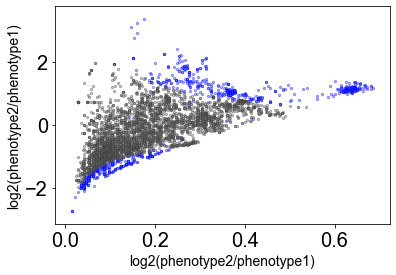

In [13]:
volcano_data = miner.differentialActivity(regulon_matrix = regulonDf.copy(),reference_matrix = overExpressedMembersMatrix.copy(),baseline_patients=phenotype1,relapse_patients=phenotype2,maxRegulons = 3,minRegulons = 3,useAllRegulons = False)
volcano_data.head()

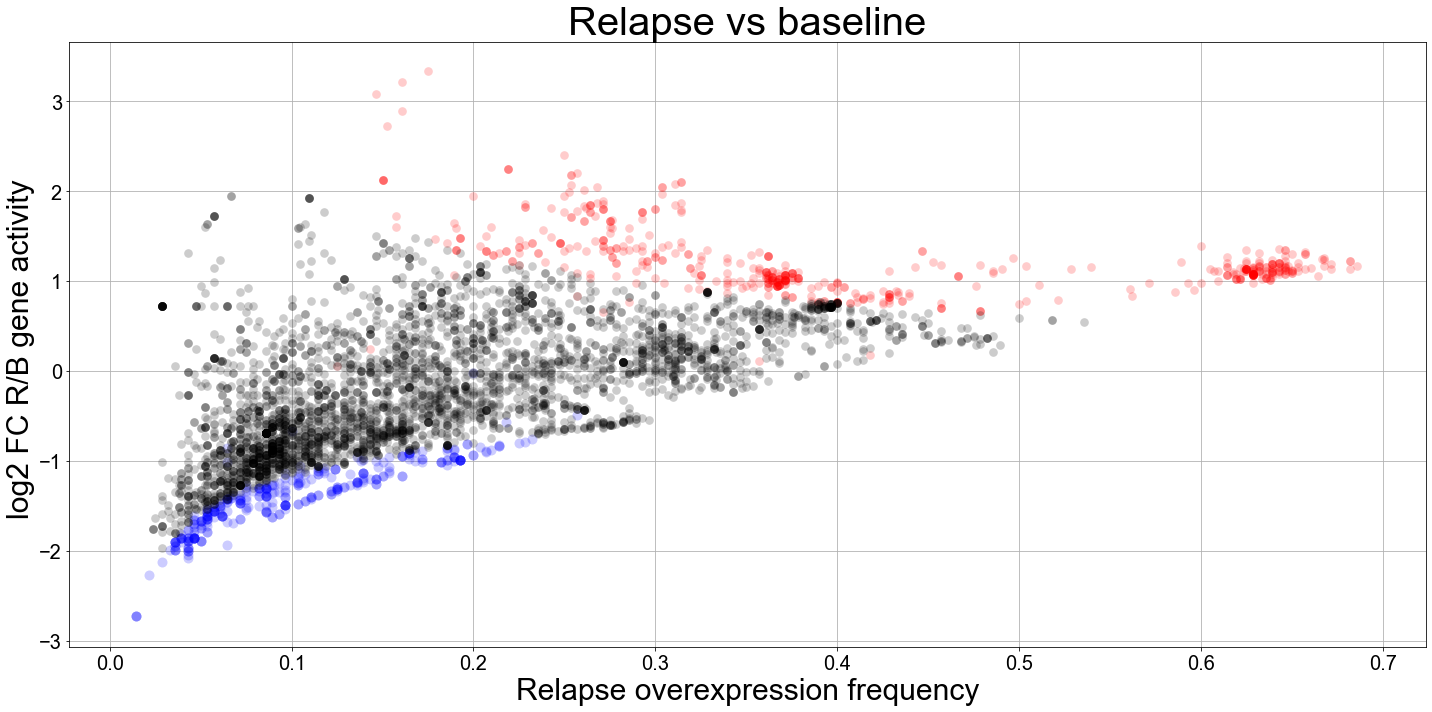

In [14]:
insigvoldata_patients = volcano_data.index[volcano_data["-log10(p)"]<=-numpy.log10(0.05)]
sigvoldata_patients_plus = volcano_data.index[(volcano_data["-log10(p)"] > -numpy.log10(0.05)) & (volcano_data['log2(phenotype2/phenotype1)'] > 0)]
sigvoldata_patients_minus = volcano_data.index[(volcano_data["-log10(p)"] > -numpy.log10(0.05)) & (volcano_data['log2(phenotype2/phenotype1)'] < 0)]

insigvoldata = volcano_data.loc[insigvoldata_patients,:]
sigvoldata_plus = volcano_data.loc[sigvoldata_patients_plus,:]
sigvoldata_minus = volcano_data.loc[sigvoldata_patients_minus,:]

fig = matplotlib.pyplot.figure(figsize=(20,10))

matplotlib.pyplot.scatter(sigvoldata_plus["phenotype2_frequency"],numpy.array(sigvoldata_plus["log2(phenotype2/phenotype1)"]),color = 'red',alpha=0.2,s=75,linewidths=0)

matplotlib.pyplot.scatter(sigvoldata_minus["phenotype2_frequency"],numpy.array(sigvoldata_minus["log2(phenotype2/phenotype1)"]),color = 'blue',alpha=0.2,s=100,linewidths=0)

matplotlib.pyplot.scatter(insigvoldata["phenotype2_frequency"],numpy.array(insigvoldata["log2(phenotype2/phenotype1)"]),color ='black',edgecolor = [0.1,0.1,0.1],alpha=0.2,s=75,linewidths=0)

matplotlib.pyplot.ylabel("log2 FC R/B gene activity ")
matplotlib.pyplot.xlabel("Relapse overexpression frequency")
matplotlib.pyplot.title('Relapse vs baseline',fontsize=40)

matplotlib.pyplot.grid()
matplotlib.pyplot.tight_layout()

In [15]:
print(sigvoldata_plus.shape)
print(sigvoldata_minus.shape)
full_df=pandas.concat([sigvoldata_plus,sigvoldata_minus])
print(full_df.shape)
full_df.rename(columns={'phenotype1_frequency':'baseline_frequency','phenotype2_frequency':'relapse_frequency','log2(phenotype2/phenotype1)':'log2(baseline/background)'},inplace=True)
full_df.to_csv(path_or_buf='relapse_vs_baseline.v2.csv')
full_df.head()

(539, 4)
(334, 4)
(873, 4)


,baseline_frequency,relapse_frequency,log2(baseline/background),-log10(p)
ENSG00000076003,0.262931,0.657143,1.321523,5.063553
ENSG00000162704,0.250000,0.642857,1.362570,5.054697
ENSG00000117632,0.254310,0.646429,1.345901,5.030854
ENSG00000119403,0.254310,0.646429,1.345901,5.030854
ENSG00000143476,0.267241,0.657143,1.298064,4.965060


# 3. Functional annotation of relapse-baseline networks

In [16]:
def reactome_formatter(json_file):
        
    output_file=json_file.replace('.json','_formatted.txt')
    synonyms_up='/Volumes/omics4tb2/alomana/projects/MINER/up_synonyms.txt'
    synonyms_down='/Volumes/omics4tb2/alomana/projects/MINER/down_synonyms.txt'
    
    # read synonyms files
    synonyms={}
    for reg in [synonyms_up,synonyms_down]:
        with open(reg,'r') as s:
            for line in s:
                v=line.split('\t')
                ensemblID=v[1]
                gene_name=v[2].split(';')[0]
                gene_symbol=v[2].split(';')[1]
                synonyms[ensemblID]=[gene_symbol,gene_name]
    # end read synonyms file
    
    g=open(output_file,'w')
    g.write('Level\tTerm\tBackground rank\tFound rank\tExpected rank\tFold enrichment\tSign\tP-value\tTranscripts\tGene symbols\tGene names\n')
    
    with open(json_file,'r') as f:
        data = json.load(f)
        for group in data['overrepresentation']['group']:
            if type(group) == dict:
                if type(group['result']) == list:
                    pathways=group['result']
                elif type(group['result']) == dict:
                    pathways=[group['result']]
                else:
                    print('ERROR: value not considered for variable group[result].')
                
                for element in pathways:
                        
                    sign=element['input_list']['plus_minus']
                    if sign == '+':
                                                                        
                        level=element['term']['level']
                        term=element['term']['label']
                        background_rank=element['number_in_reference']
                        found_rank=element['input_list']['number_in_list']
                        expected_rank=element['input_list']['expected']
                        fold_enrichment=element['input_list']['fold_enrichment']
                        pvalue=element['input_list']['pValue']
                        
                        working_variable=element['input_list']['mapped_id_list']['mapped_id']
                        if type(working_variable) == list:
                            transcripts=working_variable
                            gene_symbols=[synonyms[ID][0] for ID in transcripts]
                            gene_names=[synonyms[ID][1] for ID in transcripts]
                        elif type(working_variable) == str:
                            transcripts=[working_variable]
                            gene_symbols=[synonyms[transcripts[0]][0]]
                            gene_names=[synonyms[transcripts[0]][1]]
                        else:
                            print('ERROR: value not considered for variable working_variable.')
                            
                        transcripts_string=', '.join(transcripts)
                        gene_symbols_string=', '.join(gene_symbols)
                        gene_names_string=', '.join(gene_names)

                        g.write('{}\t'.format(level))
                        g.write('{}\t'.format(term))
                        g.write('{}\t'.format(background_rank))
                        g.write('{}\t'.format(found_rank))
                        g.write('{}\t'.format(expected_rank))
                        g.write('{}\t'.format(fold_enrichment))
                        g.write('{}\t'.format(sign))
                        g.write('{}\t'.format(pvalue))
                        g.write('{}\t'.format(transcripts_string))
                        g.write('{}\t'.format(gene_symbols_string))
                        g.write('{}'.format(gene_names_string))

                        g.write('\n')
        
    g.close()
    
    return output_file

In [17]:
def panther_formatter(json_file):
        
    output_file=json_file.replace('.json','_formatted.txt')
    synonyms_up='/Volumes/omics4tb2/alomana/projects/MINER/up_synonyms.txt'
    synonyms_down='/Volumes/omics4tb2/alomana/projects/MINER/down_synonyms.txt'
    
    # read synonyms files
    synonyms={}
    for reg in [synonyms_up,synonyms_down]:
        with open(reg,'r') as s:
            for line in s:
                v=line.split('\t')
                ensemblID=v[1]
                gene_name=v[2].split(';')[0]
                gene_symbol=v[2].split(';')[1]
                synonyms[ensemblID]=[gene_symbol,gene_name]
    # end read synonyms file
    
    g=open(output_file,'w')
    g.write('Term\tBackground rank\tFound rank\tExpected rank\tFold enrichment\tSign\tP-value\tTranscripts\tGene symbols\tGene names\n')
    
    with open(json_file,'r') as f:
        data = json.load(f)
        for group in data['overrepresentation']['group']:
            if type(group) == dict:
                if type(group['result']) == list:
                    pathways=group['result']
                elif type(group['result']) == dict:
                    pathways=[group['result']]
                else:
                    print('ERROR: value not considered for variable group[result].')
                
                for element in pathways:
                    pvalue=element['input_list']['pValue']
                    sign=element['input_list']['plus_minus']
                    
                    if pvalue < 0.05 and sign == '+':
                        
                        term=element['term']['label']
                        background_rank=element['number_in_reference']
                        found_rank=element['input_list']['number_in_list']
                        expected_rank=element['input_list']['expected']
                        fold_enrichment=element['input_list']['fold_enrichment']
                        
                        working_variable=element['input_list']['mapped_id_list']['mapped_id']
                        transcripts=working_variable
                        gene_symbols=[synonyms[ID][0] for ID in transcripts]
                        gene_names=[synonyms[ID][1] for ID in transcripts]
                        
                        transcripts_string=', '.join(transcripts)
                        gene_symbols_string=', '.join(gene_symbols)
                        gene_names_string=', '.join(gene_names)

                        g.write('{}\t'.format(term))
                        g.write('{}\t'.format(background_rank))
                        g.write('{}\t'.format(found_rank))
                        g.write('{}\t'.format(expected_rank))
                        g.write('{}\t'.format(fold_enrichment))
                        g.write('{}\t'.format(sign))
                        g.write('{}\t'.format(pvalue))
                        g.write('{}\t'.format(transcripts_string))
                        g.write('{}\t'.format(gene_symbols_string))
                        g.write('{}'.format(gene_names_string))

                        g.write('\n')
                    
    g.close()
    
    return output_file

## 3.1. Upregulation

In [18]:
json_file='/Volumes/omics4tb2/alomana/projects/MINER/up_reactome_pathways.json'
output_file=reactome_formatter(json_file)
df=pandas.read_csv(output_file,sep='\t',index_col='Term')
print(df.shape)
df.head(n=df.shape[0])

(66, 10)


,Level,Background rank,Found rank,Expected rank,Fold enrichment,Sign,P-value,Transcripts,Gene symbols,Gene names
Term,,,,,,,,,,
Unwinding of DNA,0,12,8,0.302915,26.410063,+,2.455665e-05,"ENSG00000112118, ENSG00000073111, ENSG00000076003, ENSG00000101003, ENSG00000104738, ENSG00000166508, ENSG00000093009, ENSG00000100297","MCM3, MCM2, MCM6, GINS1, MCM4, MCM7, CDC45, MCM5","DNA replication licensing factor MCM3, DNA replication licensing factor MCM2, DNA replication licensing factor MCM6, DNA replication complex GINS protein PSF1, DNA replication licensing factor MCM4, DNA replication licensing factor MCM7, Cell division control protein 45 homolog, DNA replication licensing factor MCM5"
DNA strand elongation,1,32,17,0.807773,21.045519,+,2.158599e-12,"ENSG00000133119, ENSG00000132646, ENSG00000198056, ENSG00000112118, ENSG00000073111, ENSG00000076003, ENSG00000111445, ENSG00000104738, ENSG00000062822, ENSG00000168496, ENSG00000146143, ENSG00000101003, ENSG00000166508, ENSG00000093009, ENSG00000100297, ENSG00000014138, ENSG00000105486","RFC3, PCNA, PRIM1, MCM3, MCM2, MCM6, RFC5, MCM4, POLD1, FEN1, PRIM2, GINS1, MCM7, CDC45, MCM5, POLA2, LIG1","Replication factor C subunit 3, Proliferating cell nuclear antigen, DNA primase small subunit, DNA replication licensing factor MCM3, DNA replication licensing factor MCM2, DNA replication licensing factor MCM6, Replication factor C subunit 5, DNA replication licensing factor MCM4, DNA polymerase delta catalytic subunit, Flap endonuclease 1, DNA primase large subunit, DNA replication complex GINS protein PSF1, DNA replication licensing factor MCM7, Cell division control protein 45 homolog, DNA replication licensing factor MCM5, DNA polymerase alpha subunit B, DNA ligase 1"
Synthesis of DNA,2,119,24,3.003906,7.989599,+,2.131062e-10,"ENSG00000133119, ENSG00000132646, ENSG00000175063, ENSG00000198056, ENSG00000091651, ENSG00000112118, ENSG00000073111, ENSG00000076003, ENSG00000111445, ENSG00000104738, ENSG00000062822, ENSG00000100479, ENSG00000159352, ENSG00000168496, ENSG00000146143, ENSG00000101003, ENSG00000166508, ENSG00000145386, ENSG00000093009, ENSG00000100297, ENSG00000167513, ENSG00000094804, ENSG00000014138, ENSG00000105486","RFC3, PCNA, UBE2C, PRIM1, ORC6, MCM3, MCM2, MCM6, RFC5, MCM4, POLD1, POLE2, PSMD4, FEN1, PRIM2, GINS1, MCM7, CCNA2, CDC45, MCM5, CDT1, CDC6, POLA2, LIG1","Replication factor C subunit 3, Proliferating cell nuclear antigen, Ubiquitin-conjugating enzyme E2 C, DNA primase small subunit, Origin recognition complex subunit 6, DNA replication licensing factor MCM3, DNA replication licensing factor MCM2, DNA replication licensing factor MCM6, Replication factor C subunit 5, DNA replication licensing factor MCM4, DNA polymerase delta catalytic subunit, DNA polymerase epsilon subunit 2, 26S proteasome non-ATPase regulatory subunit 4, Flap endonuclease 1, DNA primase large subunit, DNA replication complex GINS protein PSF1, DNA replication licensing factor MCM7, Cyclin-A2, Cell division control protein 45 homolog, DNA replication licensing factor MCM5, DNA replication factor Cdt1, Cell division control protein 6 homolog, DNA polymerase alpha subunit B, DNA ligase 1"
S Phase,3,161,31,4.064107,7.627751,+,1.616885e-13,"ENSG00000175063, ENSG00000072501, ENSG00000073111, ENSG00000171320, ENSG00000076003, ENSG00000173207, ENSG00000062822, ENSG00000159352, ENSG00000168496, ENSG00000146143, ENSG00000101412, ENSG00000094804, ENSG00000133119, ENSG00000132646, ENSG00000183814, ENSG00000198056, ENSG00000091651, ENSG00000112118, ENSG00000111445, ENSG00000104738, ENSG00000164045, ENSG00000100479, ENSG00000101003, ENSG00000166508, ENSG00000145386, ENSG00000093009, ENSG00000100297, ENSG00000167513, ENSG00000162521, ENSG00000014138, ENSG00000105486","UBE2C, SMC1A, MCM2, ESCO2, MCM6, CKS1B, POLD1, PSMD4, FEN1, PRIM2, E2F1, CDC6, RFC3, PCNA, LIN9, PRIM1, ORC6, MCM3, RFC5, MCM4, CDC25A, POLE2, GINS1, MCM7, CCNA2, CDC45, MCM5, CDT1, RBBP4, POLA2, LIG1","Ubiquitin-conjugating enzyme E2 C, Struc

In [19]:
specifics=df['Level'] == 0
new=df[specifics]
print(new.shape)
new.head(n=new.shape[0])

(27, 10)


,Level,Background rank,Found rank,Expected rank,Fold enrichment,Sign,P-value,Transcripts,Gene symbols,Gene names
Term,,,,,,,,,,
Unwinding of DNA,0,12,8,0.302915,26.410063,+,2.455665e-05,"ENSG00000112118, ENSG00000073111, ENSG00000076003, ENSG00000101003, ENSG00000104738, ENSG00000166508, ENSG00000093009, ENSG00000100297","MCM3, MCM2, MCM6, GINS1, MCM4, MCM7, CDC45, MCM5","DNA replication licensing factor MCM3, DNA replication licensing factor MCM2, DNA replication licensing factor MCM6, DNA replication complex GINS protein PSF1, DNA replication licensing factor MCM4, DNA replication licensing factor MCM7, Cell division control protein 45 homolog, DNA replication licensing factor MCM5"
Polymerase switching on the C-strand of the telomere,0,14,7,0.353401,19.807547,+,8.969234e-04,"ENSG00000062822, ENSG00000133119, ENSG00000132646, ENSG00000198056, ENSG00000146143, ENSG00000111445, ENSG00000014138","POLD1, RFC3, PCNA, PRIM1, PRIM2, RFC5, POLA2","DNA polymerase delta catalytic subunit, Replication factor C subunit 3, Proliferating cell nuclear antigen, DNA primase small subunit, DNA primase large subunit, Replication factor C subunit 5, DNA polymerase alpha subunit B"
Polymerase switching,0,14,7,0.353401,19.807547,+,8.969234e-04,"ENSG00000062822, ENSG00000133119, ENSG00000132646, ENSG00000198056, ENSG00000146143, ENSG00000111445, ENSG00000014138","POLD1, RFC3, PCNA, PRIM1, PRIM2, RFC5, POLA2","DNA polymerase delta catalytic subunit, Replication factor C subunit 3, Proliferating cell nuclear antigen, DNA primase small subunit, DNA primase large subunit, Replication factor C subunit 5, DNA polymerase alpha subunit B"
Polo-like kinase mediated events,0,16,8,0.403886,19.807547,+,1.314385e-04,"ENSG00000164045, ENSG00000183814, ENSG00000166851, ENSG00000111206, ENSG00000117724, ENSG00000101057, ENSG00000127564, ENSG00000162521","CDC25A, LIN9, PLK1, FOXM1, CENPF, MYBL2, PKMYT1, RBBP4","M-phase inducer phosphatase 1, Protein lin-9 homolog, Serine/threonine-protein kinase PLK1, Forkhead box protein M1, Centromere protein F, Myb-related protein B, Membrane-associated tyrosine- and threonine-specific cdc2-inhibitory kinase, Histone-binding protein RBBP4"
Activation of E2F1 target genes at G1/S,0,28,13,0.706801,18.392722,+,1.956236e-08,"ENSG00000132646, ENSG00000183814, ENSG00000080839, ENSG00000176890, ENSG00000170312, ENSG00000228716, ENSG00000171848, ENSG00000101412, ENSG00000093009, ENSG00000167900, ENSG00000167513, ENSG00000162521, ENSG00000094804","PCNA, LIN9, RBL1, TYMS, CDK1, DHFR, RRM2, E2F1, CDC45, TK1, CDT1, RBBP4, CDC6","Proliferating cell nuclear antigen, Protein lin-9 homolog, Retinoblastoma-like protein 1, Thymidylate synthase, Cyclin-dependent kinase 1, Dihydrofolate reductase, Ribonucleoside-diphosphate reductase subunit M2, Transcription factor E2F1, Cell division control protein 45 homolog, Thymidine kinase, cytosolic, DNA replication factor Cdt1, Histone-binding protein RBBP4, Cell division control protein 6 homolog"
Activation of the pre-replicative complex,0,33,15,0.833016,18.006861,+,6.222437e-10,"ENSG00000198056, ENSG00000091651, ENSG00000112118, ENSG00000073111, ENSG00000076003, ENSG00000104738, ENSG00000097046, ENSG00000100479, ENSG00000146143, ENSG00000166508, ENSG00000093009, ENSG00000100297, ENSG00000167513, ENSG00000094804, ENSG00000014138","PRIM1, ORC6, MCM3, MCM2, MCM6, MCM4, CDC7, POLE2, PRIM2, MCM7, CDC45, MCM5, CDT1, CDC6, POLA2","DNA primase small subunit, Origin recognition complex subunit 6, DNA replication licensing factor MCM3, DNA replication licensing factor MCM2, DNA replication licensing factor MCM6, DNA replication licensing factor MCM4, Cell division cycle 7-related protein kinase, DNA polymerase epsilon subunit 2, DNA primase large subunit, DNA replication licensing factor MCM7, Cell division control protein 45 homolog, DNA replication licensing factor MCM5, DNA replication factor Cdt1, Cell division control protein 6 homolog, DNA polymerase alpha subunit B"
Transcription of E2F targets under nega

## 3.2. Downregulation

In [20]:

json_file='/Volumes/omics4tb2/alomana/projects/MINER/down_panther_pathways.json'
output_file=panther_formatter(json_file)
df=pandas.read_csv(output_file,sep='\t',index_col='Term')
print(df.shape)
df.head(n=df.shape[0])

(1, 9)


,Background rank,Found rank,Expected rank,Fold enrichment,Sign,P-value,Transcripts,Gene symbols,Gene names
Term,,,,,,,,,
Gonadotropin-releasing hormone receptor pathway,230,13,3.625929,3.585288,+,0.018178,"ENSG00000096433, ENSG00000100393, ENSG00000143190, ENSG00000138814, ENSG00000118260, ENSG00000135341, ENSG00000114166, ENSG00000141068, ENSG00000198909, ENSG00000120899, ENSG00000134909, ENSG00000162772, ENSG00000144895","ITPR3, EP300, POU2F1, PPP3CA, CREB1, MAP3K7, KAT2B, KSR1, MAP3K3, PTK2B, ARHGAP32, ATF3, EIF2A","Inositol 1,4,5-trisphosphate receptor type 3, Histone acetyltransferase p300, POU domain, class 2, transcription factor 1, Serine/threonine-protein phosphatase 2B catalytic subunit alpha isoform, Cyclic AMP-responsive element-binding protein 1, Mitogen-activated protein kinase kinase kinase 7, Histone acetyltransferase KAT2B, Kinase suppressor of Ras 1, Mitogen-activated protein kinase kinase kinase 3, Protein-tyrosine kinase 2-beta, Rho GTPase-activating protein 32, Cyclic AMP-dependent transcription factor ATF-3, Eukaryotic translation initiation factor 2A"
